### 1. Purpose of this notebook

The purpose of this notebook is to create a predictive model to classify customers and allow the company to maximize profit from the next marketing campaign.

> Predictive model 
- We used two models to try to predict the classification, decision tree and logistic regression. Logistic regression proved to be better, being more accurate in the true positives.

> Predictor variables
- We chose the predictor variables from the exploratory analysis (EDA) and after several tests.

> Model's metrics
- We adopted AUC as the main metric for the model. In our case, in which we have an imbalance of results (more True than False), it is more important to us
consider the consumer to be false when it is true, than to consider it to be true when it is false (thus preventing further loss of investment). Although the AUC of the logistic regression was around 0.81, in the executions we made there was a variation of about 0.1 (0.73 - 0.83).

#### Results

With the logistic regression model we can predict which customers are most probability to buy the gadget. However, by favoring a better success rate, we have a smaller number of customers.

We made a suggestion of an approach where we not only take into account the success rate, but the profit. We built a table where, based on the results of the model, we can define an acceptable probability (for example, 30%). Thus, for customers with more than 30% probability of buying the gadget, we will carry out the campaign. This allows us to send the campaign to more customers generating more cost, but also allowing for greater revenue.

### 2. Read data

#### 2.1 Import Python packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

from src.paths import DATA
import src.eda as eda

%matplotlib inline
plt.style.use('bmh')
%load_ext autoreload
%autoreload 2

In [51]:
df = pd.read_csv(DATA / 'ml_project1_data_pre_processed.csv')

#Transform to dummy columns
df_dummy_columns = pd.get_dummies(df[['Education','Marital_Status']])
df = pd.concat([df,df_dummy_columns], axis=1)

#removed outliers
df = df.query("Income < 118000")
df = df[df.Income.notnull()]
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,1,0,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,1,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,0,1,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,0,1,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,1,0,0,0,1,0,0,0,0


### 3. Predictive model

In [52]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Response',
       'Z_Revenue_correct', 'Age', 'MntTotal', 'NumTotalPurchases',
       'AcceptedTotalFirstFiveCmps', 'AcceptedTotalFirstFiveCmpsMorePilot',
       'TotalYearAfterRegistration', 'TotalChildren', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Ma

#### 3.1 Customer behaviors used

We chose these products based on exploratory data analysis and tests performed here.

In [53]:
columns =['Recency', 'MntTotal', 'Income', 'Response','Education_2n Cycle',
       'Education_Master',
       'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single',
       'AcceptedTotalFirstFiveCmps']

df_train = df[columns]

In [54]:
#Define train dataset
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('Response',axis=1), df_train['Response'],test_size=0.3)

In [55]:
#size of datasets
[X_train.shape, X_test.shape,
y_train.shape, y_test.shape]

[(1542, 10), (661, 10), (1542,), (661,)]

#### 3.2 Definition of the best model

#### 3.2.1 Decision Tree

In [56]:
model1 = DecisionTreeClassifier()
model1 = model1.fit(X_train,y_train)

In [57]:
for feature, importancies in zip(df.drop('Response',axis=1), model1.feature_importances_):
    print(f"{feature}:{importancies:.3f}")

ID:0.216
Year_Birth:0.230
Education:0.223
Marital_Status:0.008
Income:0.019
Kidhome:0.018
Teenhome:0.016
Dt_Customer:0.019
Recency:0.047
MntWines:0.204


In [58]:
results_decision_tree = model1.predict(X_test)
print(metrics.classification_report(y_test, results_decision_tree))

              precision    recall  f1-score   support

       False       0.91      0.90      0.90       566
        True       0.44      0.47      0.45        95

    accuracy                           0.84       661
   macro avg       0.67      0.69      0.68       661
weighted avg       0.84      0.84      0.84       661



In [59]:
decision_tree_matrix = metrics.confusion_matrix(y_test, results_decision_tree)
decision_tree_matrix

array([[508,  58],
       [ 50,  45]], dtype=int64)

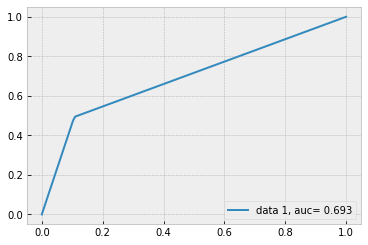

In [60]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"data 1, auc= {auc:.3f}")
plt.legend(loc=4)
plt.show()

The AUC value does not look very good and the precision in hitting true positives was below 0.50.

#### 3.2.2 Logistic Regression

In [61]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [62]:
results_logistic_regression = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [63]:
print(metrics.classification_report(y_test, results_logistic_regression))

              precision    recall  f1-score   support

       False       0.90      0.97      0.93       566
        True       0.67      0.35      0.46        95

    accuracy                           0.88       661
   macro avg       0.79      0.66      0.70       661
weighted avg       0.87      0.88      0.87       661



In [64]:
logistic_regression_matrix = metrics.confusion_matrix(y_test, results_logistic_regression)
logistic_regression_matrix

array([[550,  16],
       [ 62,  33]], dtype=int64)

In [65]:
print("Accuracy:", metrics.accuracy_score(y_test, results_logistic_regression).round(2))
print("Precision:", metrics.precision_score(y_test, results_logistic_regression).round(2))
print("Recall:", metrics.recall_score(y_test, results_logistic_regression).round(2))

Accuracy: 0.88
Precision: 0.67
Recall: 0.35


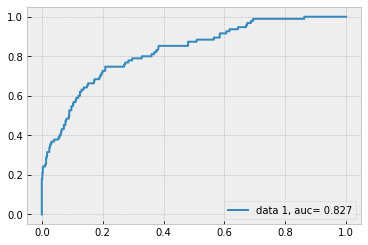

In [66]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=f"data 1, auc= {auc:.3f}")
plt.legend(loc=4)
plt.show()

The AUC value proved to be much better than in the decision tree. In addition, the accuracy in true positives was 0.72.

### 4. Applying the model

Applying the model to the dataset we have, we obtain the following results:

In [67]:
df['prob_true'] = logreg.predict_proba(df[columns].drop('Response', axis=1))[:,1]
df['result_pred'] = df['prob_true'].apply(lambda x: True if x >= 0.5 else False)
df.sample(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,prob_true,result_pred
218,1377,1954,Master,Widow,44551.0,0,1,2013-08-31,24,182,...,0,0,0,0,0,0,1,0,0.114629,False
1224,7736,1986,Graduation,Married,22518.0,1,0,2012-10-22,36,11,...,0,0,0,1,0,0,0,0,0.303849,False
1464,7196,1950,PhD,Married,41145.0,1,1,2014-02-08,20,9,...,0,0,0,1,0,0,0,0,0.094794,False
1078,247,1971,Graduation,Married,36715.0,1,0,2012-11-17,16,172,...,0,0,0,1,0,0,0,0,0.155729,False
2000,3599,1970,Graduation,Married,63684.0,0,1,2012-11-26,61,575,...,0,0,0,1,0,0,0,0,0.074388,False


result_pred    173
Response       117
dtype: int64

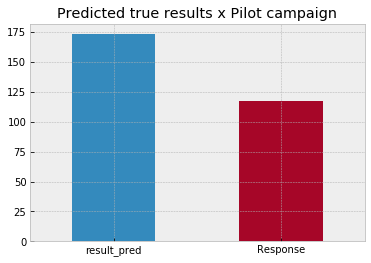

In [68]:
(df.query("result_pred == 1")[['result_pred','Response']]
 .sum()
 .plot
 .bar())
plt.title("Predicted true results x Pilot campaign")
plt.xticks(rotation=0);

df.query("result_pred == 1")[['result_pred','Response']].sum()

The model predicted that 165 customers would buy the gadget, however, looking at the responses we got in the pilot campaign, only 115 would actually buy.
This would give us a 70% success rate - better than the pilot's 15%. In terms of financial results, we would have a revenue of 1265 and a cost of 345 (profit of 920).

But, we have a problem: despite the good result in the success rate, we have a few customers. We can lower the probability limit by setting True or False (which is currently 0.5):

In [69]:
df['result_pred_30p'] = df['prob_true'].apply(lambda x: True if x >= 0.30 else False)
df.sample(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,prob_true,result_pred,result_pred_30p
1371,8805,1960,Graduation,Single,48904.0,0,1,2012-12-02,1,283,...,0,0,0,1,0,0,0,0.262842,False,False
1631,5209,1954,Graduation,Divorced,50002.0,0,1,2013-06-17,21,443,...,0,1,0,0,0,0,0,0.174377,False,False
1116,2320,1978,2n Cycle,Married,47025.0,0,1,2013-09-12,98,508,...,0,0,1,0,0,0,0,0.015349,False,False
1938,5015,1976,Master,Married,34529.0,1,0,2012-09-14,94,68,...,0,0,1,0,0,0,0,0.014877,False,False
1728,10129,1966,Graduation,Together,82427.0,0,0,2014-03-12,35,482,...,0,0,0,0,1,0,0,0.320095,False,True


result_pred_30p    309
Response           168
dtype: int64

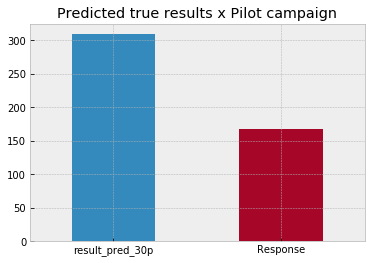

In [70]:
(df.query("result_pred_30p == 1")[['result_pred_30p','Response']]
 .sum()
 .plot
 .bar())
plt.title("Predicted true results x Pilot campaign")
plt.xticks(rotation=0);

df.query("result_pred_30p == 1")[['result_pred_30p','Response']].sum()

Now, we have 54% success rate - better than the pilot's 15%. In terms of financial results, we would have a revenue of 1793 and a cost of 900 (profit of 893).

As a suggestion, let's create a table containing the probability limits for True or False between 0 and 1. This way, we will know which probability value that optimizes the profit.

#### 4.1 Profit optimization

In [71]:
eda.optimal_probability(df).head(20)

,limit_prob,result_pred,response,revenue_previst,cost_previst,profit_previst,tx_sucess
24,24,420,206,2266,1260,1006,0.5
25,25,397,199,2189,1191,998,0.5
28,28,339,182,2002,1017,985,0.5
23,23,443,210,2310,1329,981,0.5
26,26,375,191,2101,1125,976,0.5
29,29,322,176,1936,966,970,0.5
27,27,355,185,2035,1065,970,0.5
22,22,467,212,2332,1401,931,0.5
31,31,305,167,1837,915,922,0.5
30,30,309,168,1848,927,921,0.5


The table shows us that if we accepted all customers with a probability greater than 0.22 as True, we would have a 50% success rate (even greater than 15% of the pilot) and an expected profit of 1012.

with pd.ExcelWriter(DATA / 'customers_to_send_the_campaign.xlsx') as excel_writer:
    df.to_excel(excel_writer, sheet_name='customers', columns=(['ID', 'prob_true']), index=False)
    eda.optimal_probability(df).to_excel(excel_writer, sheet_name='profit_optimization', index=False)